# Human heart cell-cell interaction analysis using Giotto

In [145]:
library(Giotto)
library(data.table)

In [168]:
# tissue = HComD2
path_to_matrix = '../output/heart/express.txt'
path_to_locations = '../output/heart/coords.txt'
path_to_celltype = '../output/heart/cell_type.txt'
my_cell_metadata = read.table(path_to_celltype)

In [169]:
my_instructions = createGiottoInstructions(python_path='/home/xwanaf/.conda/envs/rbayes/bin/python')
my_giotto_object = createGiottoObject(raw_exprs = path_to_matrix,
                                      spatial_locs = path_to_locations,
                                      cell_metadata = my_cell_metadata,
                                      instructions = my_instructions)
my_giotto_object@cell_metadata$cell_types <- my_giotto_object@cell_metadata$V1


 external python path provided and will be used 
Consider to install these (optional) packages to run all possible Giotto commands for spatial analyses:  MAST smfishHmrf trendsceek SPARK multinet RTriangle FactoMiner
 Giotto does not automatically install all these packages as they are not absolutely required and this reduces the number of dependencies

return_plot = TRUE and return_gobject = TRUE 

          plot will not be returned to object, but can still be saved with save_plot = TRUE or manually 
hvg  was found in the gene metadata information and will be used to select highly variable genes 


Warning message in runPCA_prcomp_irlba(x = t_giotto(expr_values), center = center, :
“ncp >= minimum dimension of x, will be set to minimum dimension of x - 1”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“did not converge--results might be invalid!; try increasing work or maxit”


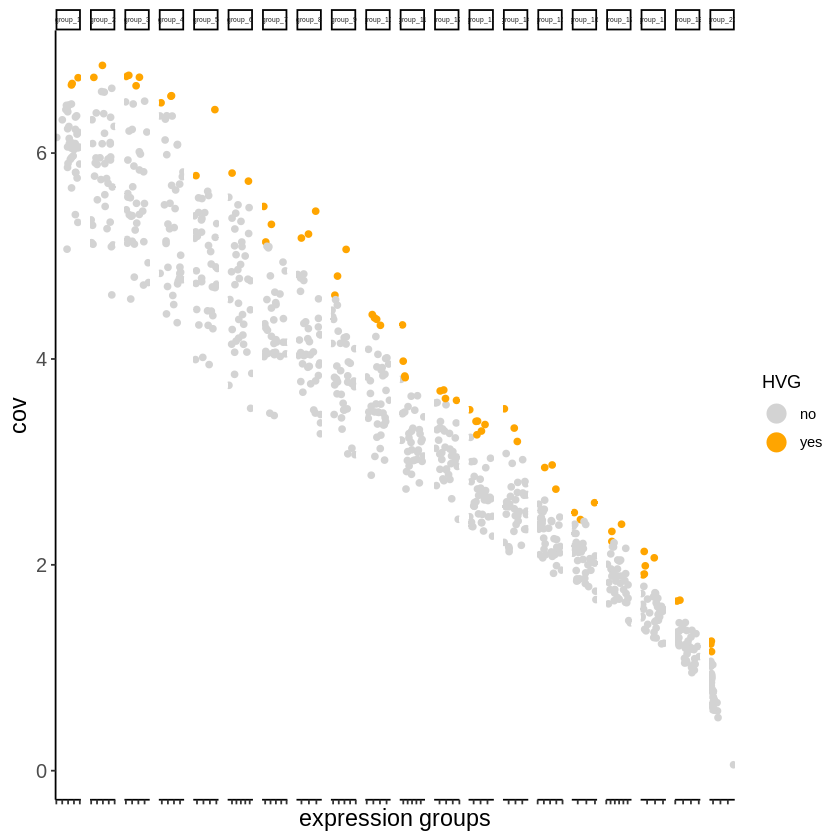

In [4]:
# processing
my_giotto_object <- filterGiotto(gobject = my_giotto_object, 
                             expression_threshold = 0.5, 
                             gene_det_in_min_cells = 20, 
                             min_det_genes_per_cell = 0)
my_giotto_object <- normalizeGiotto(gobject = my_giotto_object)

# dimension reduction
my_giotto_object <- calculateHVG(gobject = my_giotto_object)
my_giotto_object <- runPCA(gobject = my_giotto_object)
my_giotto_object <- runUMAP(my_giotto_object, dimensions_to_use = 1:5)
my_giotto_object <- createNearestNetwork(my_giotto_object)

In [5]:
# # annotate
# metadata = pDataDT(my_giotto_object)
# uniq_clusters = length(unique(metadata$leiden_clus))

# clusters_cell_types = paste0('cell ', LETTERS[1:uniq_clusters])
# names(clusters_cell_types) = 1:uniq_clusters

# my_giotto_object = annotateGiotto(gobject = my_giotto_object, 
#                               annotation_vector = clusters_cell_types, 
#                               cluster_column = 'leiden_clus', 
#                               name = 'cell_types')

# create network (required for binSpect methods)
my_giotto_object = createSpatialNetwork(gobject = my_giotto_object, minimum_k = 2)

# identify genes with a spatial coherent expression profile
km_spatialgenes = binSpect(my_giotto_object, bin_method = 'kmeans')


 This is the single parameter version of binSpect
 1. matrix binarization complete 

 2. spatial enrichment test completed 

 3. (optional) average expression of high expressing cells calculated 

 4. (optional) number of high expressing cells calculated 


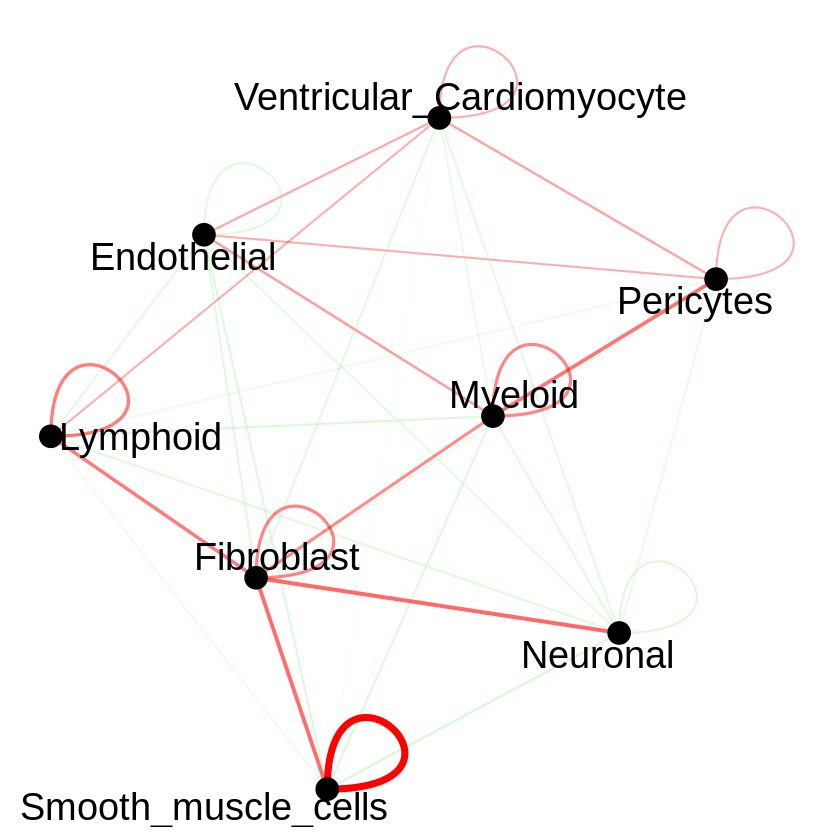

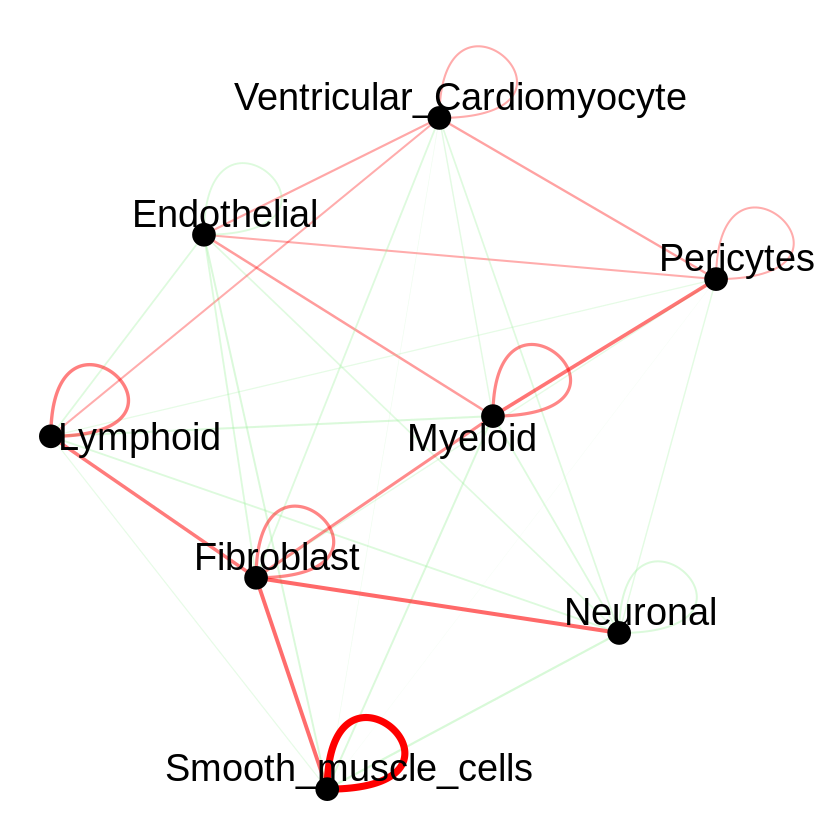

In [6]:
set.seed(seed = 2841)
cell_proximities = cellProximityEnrichment(gobject = my_giotto_object,
                                           cluster_column = 'cell_types',
                                           spatial_network_name = 'Delaunay_network',
                                           adjust_method = 'fdr',
                                           number_of_simulations = 1000)
# network with self-edges
cellProximityNetwork(gobject = my_giotto_object, CPscore = cell_proximities,
                     remove_self_edges = F, self_loop_strength = 0.3,
                     only_show_enrichment_edges = F,
                     rescale_edge_weights = T,
                     node_size = 6, node_text_size=8,
                     edge_weight_range_depletion = c(1, 2),
                     edge_weight_range_enrichment = c(2,5))

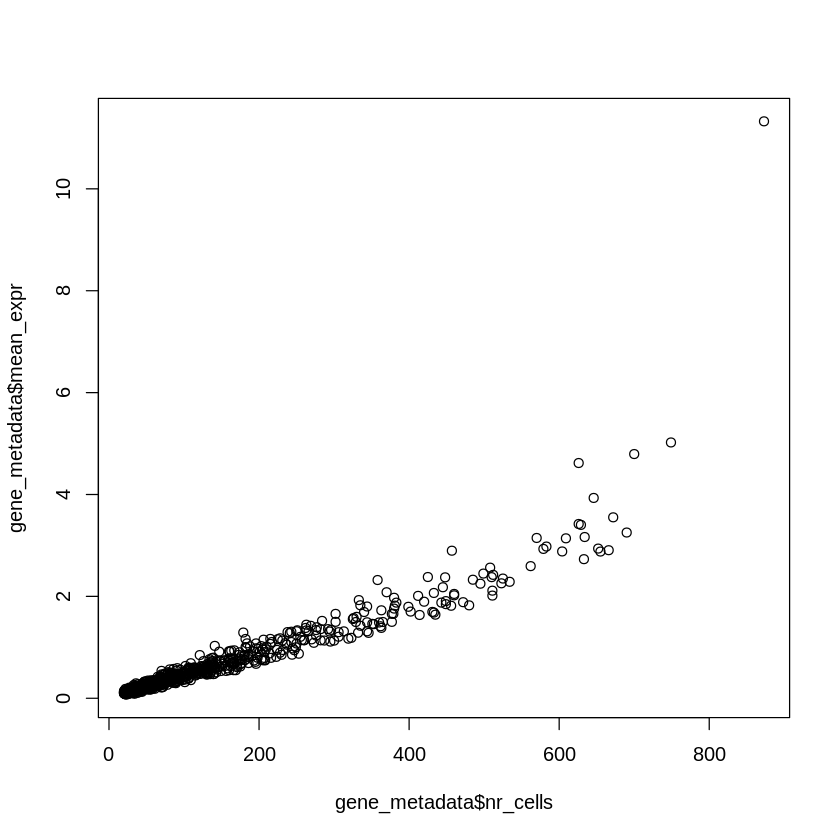

0%       25%       50%       75%      100% 
 2.265744  3.634272  4.057809  4.648682 11.325538

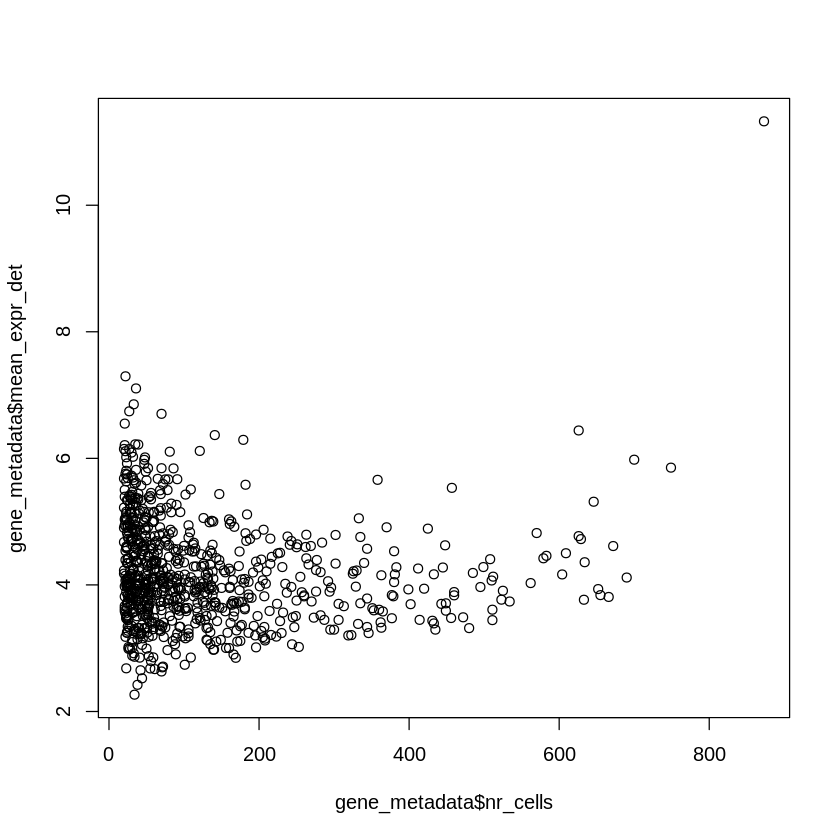

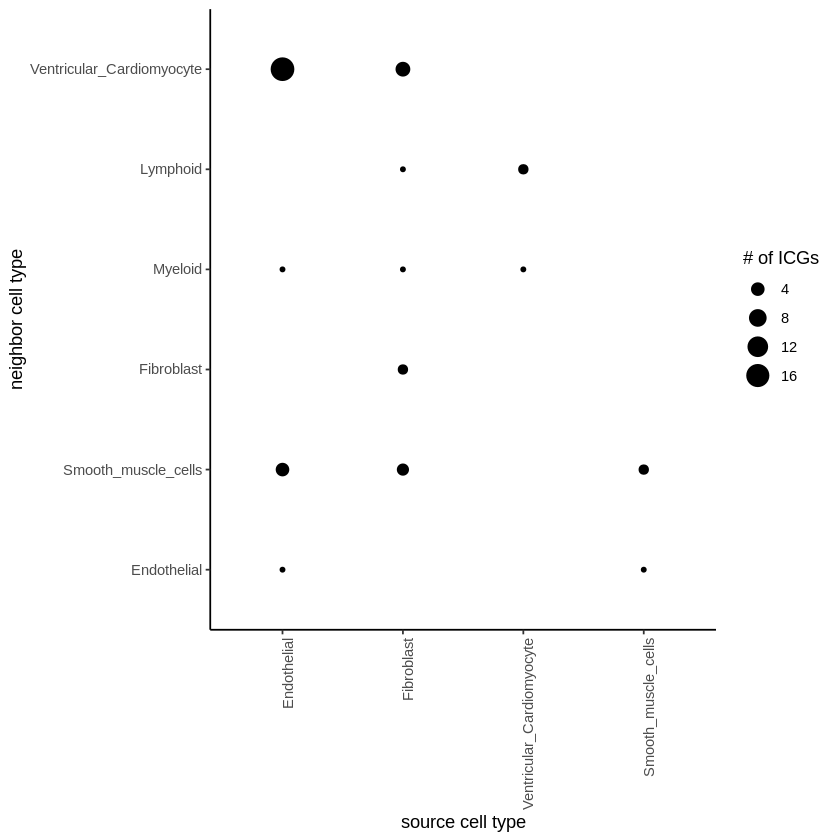

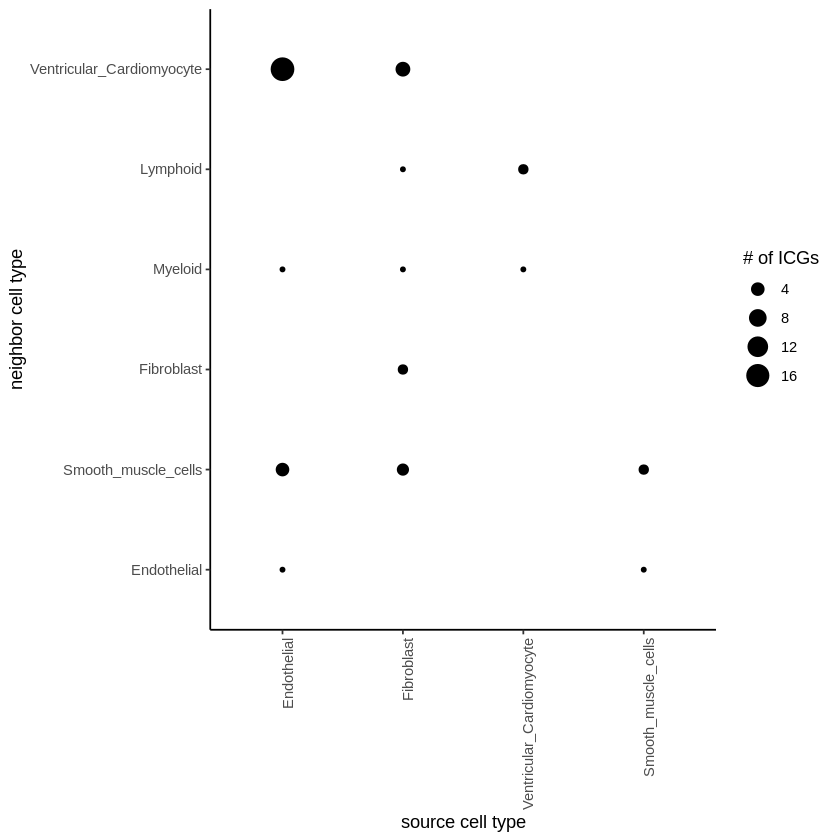

In [7]:
my_giotto_object <- addGeneStatistics(my_giotto_object)

## select top 25th highest expressing genes
gene_metadata = fDataDT(my_giotto_object)
plot(gene_metadata$nr_cells, gene_metadata$mean_expr)
plot(gene_metadata$nr_cells, gene_metadata$mean_expr_det)

quantile(gene_metadata$mean_expr_det)
high_expressed_genes = gene_metadata[mean_expr_det > 4]$gene_ID

## identify genes that are associated with proximity to other cell types
ICGscoresHighGenes =  findICG(gobject = my_giotto_object,
                              selected_genes = high_expressed_genes,
                              spatial_network_name = 'Delaunay_network',
                              cluster_column = 'cell_types',
                              diff_test = 'permutation',
                              adjust_method = 'fdr',
                              nr_permutations = 500,
                              do_parallel = T, cores = 2)

## visualize all genes
plotCellProximityGenes(my_giotto_object, cpgObject = ICGscoresHighGenes, method = 'dotplot')

## filter genes
ICGscoresFilt = filterICG(ICGscoresHighGenes, 
                          min_cells = 2, min_int_cells = 2, min_fdr = 0.1,
                          min_spat_diff = 0.1, min_log2_fc = 0.1, min_zscore = 0.0)
# ICGscoresFilt = filterICG(ICGscoresHighGenes, 
#                           min_cells = 2, min_int_cells = 2, min_fdr = 0.1,
#                           min_spat_diff = 0.1, min_log2_fc = 0.1, min_zscore = 1)


In [8]:
# write.csv(ICGscoresHighGenes$CPGscores, '/home/share/xwanaf/sour_sep/newCKPT/MerM/giotto_data/ICGscoresHighGenes.csv', row.names = FALSE)
# write.csv(ICGscoresFilt$CPGscores, '/home/share/xwanaf/sour_sep/newCKPT/MerM/giotto_data/ICGscoresFilt_zscore0.csv', row.names = FALSE)

simulation  1 
simulation  2 
simulation  3 
simulation  4 
simulation  5 
simulation  6 
simulation  7 
simulation  8 
simulation  9 
simulation  10 
simulation  11 
simulation  12 
simulation  13 
simulation  14 
simulation  15 
simulation  16 
simulation  17 
simulation  18 
simulation  19 
simulation  20 
simulation  21 
simulation  22 
simulation  23 
simulation  24 
simulation  25 
simulation  26 
simulation  27 
simulation  28 
simulation  29 
simulation  30 
simulation  31 
simulation  32 
simulation  33 
simulation  34 
simulation  35 
simulation  36 
simulation  37 
simulation  38 
simulation  39 
simulation  40 
simulation  41 
simulation  42 
simulation  43 
simulation  44 
simulation  45 
simulation  46 
simulation  47 
simulation  48 
simulation  49 
simulation  50 
simulation  51 
simulation  52 
simulation  53 
simulation  54 
simulation  55 
simulation  56 
simulation  57 
simulation  58 
simulation  59 
simulation  60 
simulation  61 
simulation  62 
simulation  63 
s

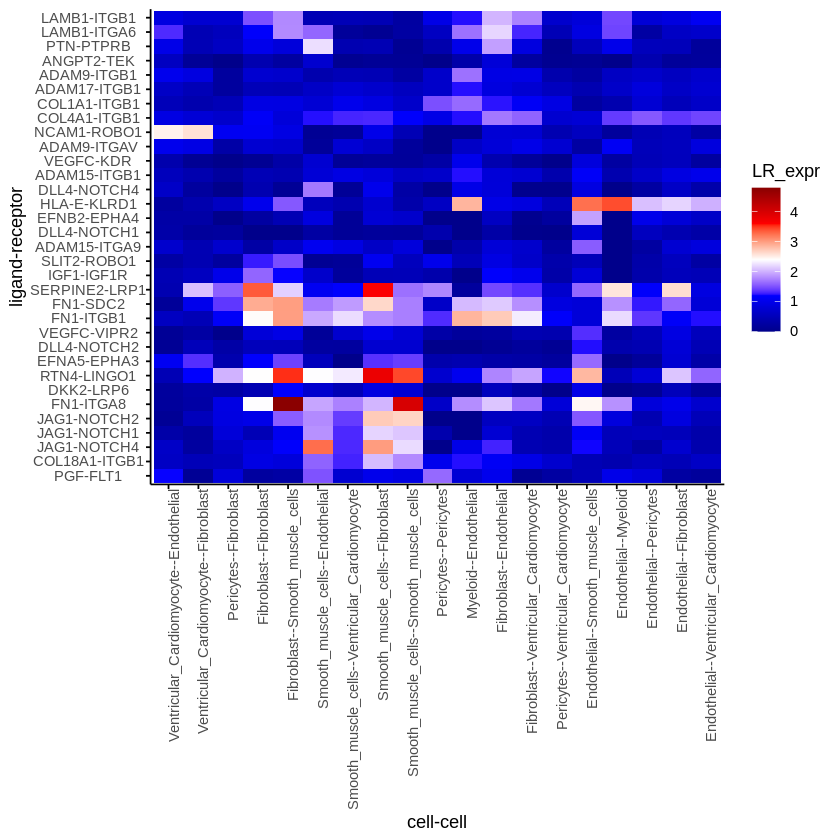

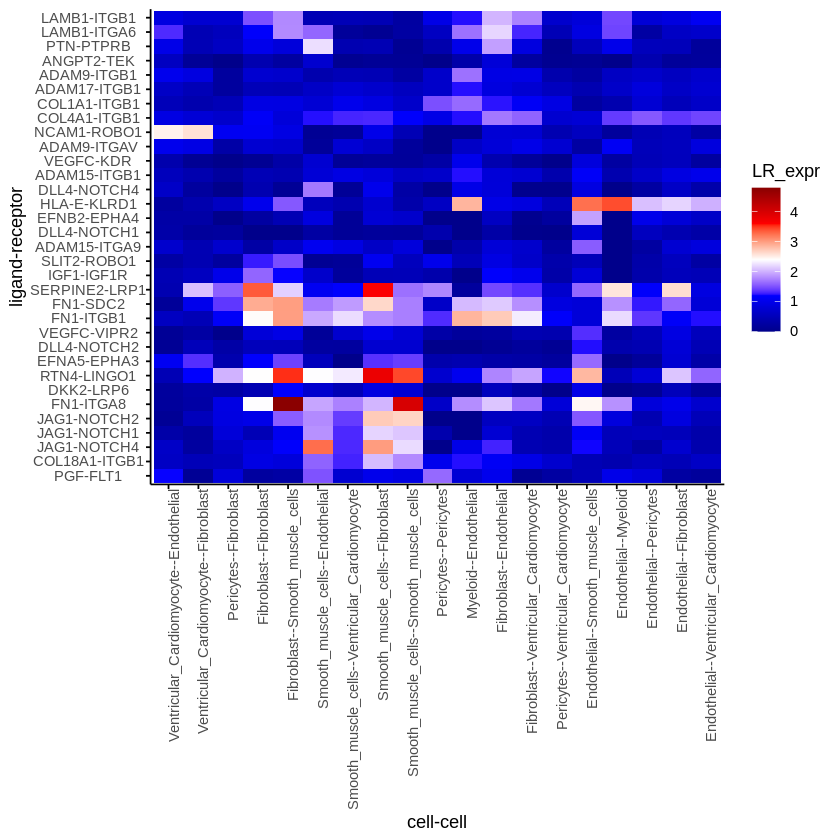

In [9]:

LR_data = data.table::fread(system.file("extdata", "mouse_ligand_receptors.txt", package = 'Giotto'))

LR_data$L_upper = toupper(LR_data$mouseLigand)
LR_data$R_upper = toupper(LR_data$mouseReceptor)
LR_data[, ligand_det := ifelse(L_upper %in% my_giotto_object@gene_ID, T, F)]
LR_data[, receptor_det := ifelse(R_upper %in% my_giotto_object@gene_ID, T, F)]
LR_data_det = LR_data[ligand_det == T & receptor_det == T]
select_ligands = LR_data_det$L_upper
select_receptors = LR_data_det$R_upper


## get statistical significance of gene pair expression changes based on expression ##
expr_only_scores = exprCellCellcom(gobject = my_giotto_object,
                                   cluster_column = 'cell_types',
                                   random_iter = 500,
                                   gene_set_1 = select_ligands,
                                   gene_set_2 = select_receptors)

## get statistical significance of gene pair expression changes upon cell-cell interaction
spatial_all_scores = spatCellCellcom(my_giotto_object,
                                     spatial_network_name = 'Delaunay_network',
                                     cluster_column = 'cell_types',
                                     random_iter = 500,
                                     gene_set_1 = select_ligands,
                                     gene_set_2 = select_receptors,
                                     adjust_method = 'fdr',
                                     do_parallel = T,
                                     cores = 4,
                                     verbose = 'none')


## * plot communication scores ####

## select top LR ##
selected_spat = spatial_all_scores[p.adj <= 0.5 & abs(log2fc) > 0.1 & lig_nr >= 10 & rec_nr >= 10]
data.table::setorder(selected_spat, -PI)

top_LR_ints = unique(selected_spat[order(-abs(PI))]$LR_comb)[1:33]
top_LR_cell_ints = unique(selected_spat[order(-abs(PI))]$LR_cell_comb)[1:33]

plotCCcomHeatmap(gobject = my_giotto_object,
                 comScores = spatial_all_scores,
                 selected_LR = top_LR_ints,
                 selected_cell_LR = top_LR_cell_ints,
                 show = 'LR_expr')

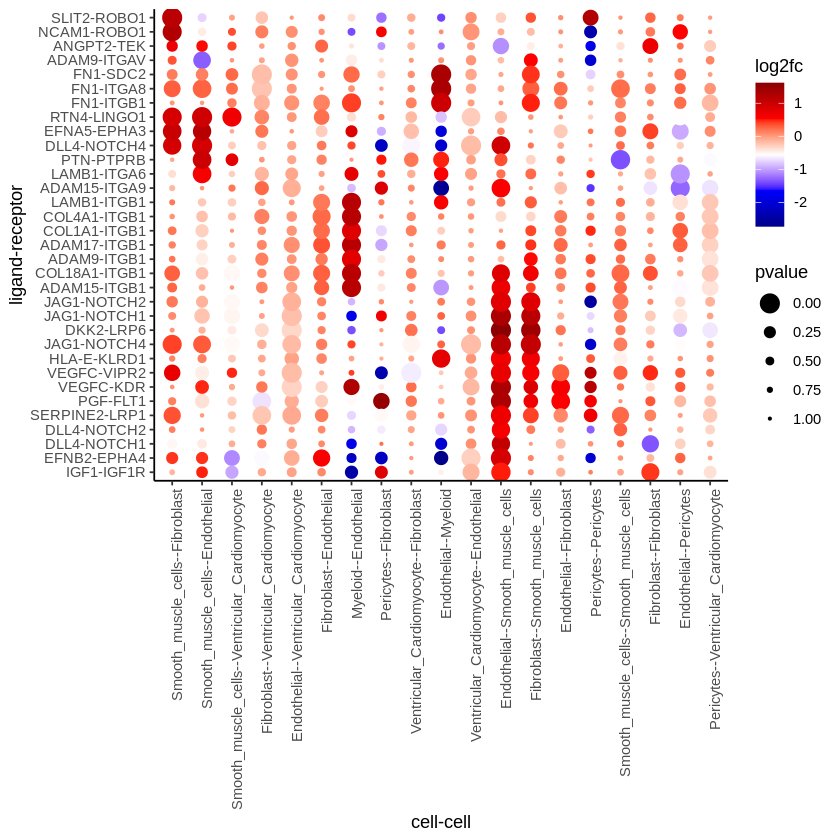

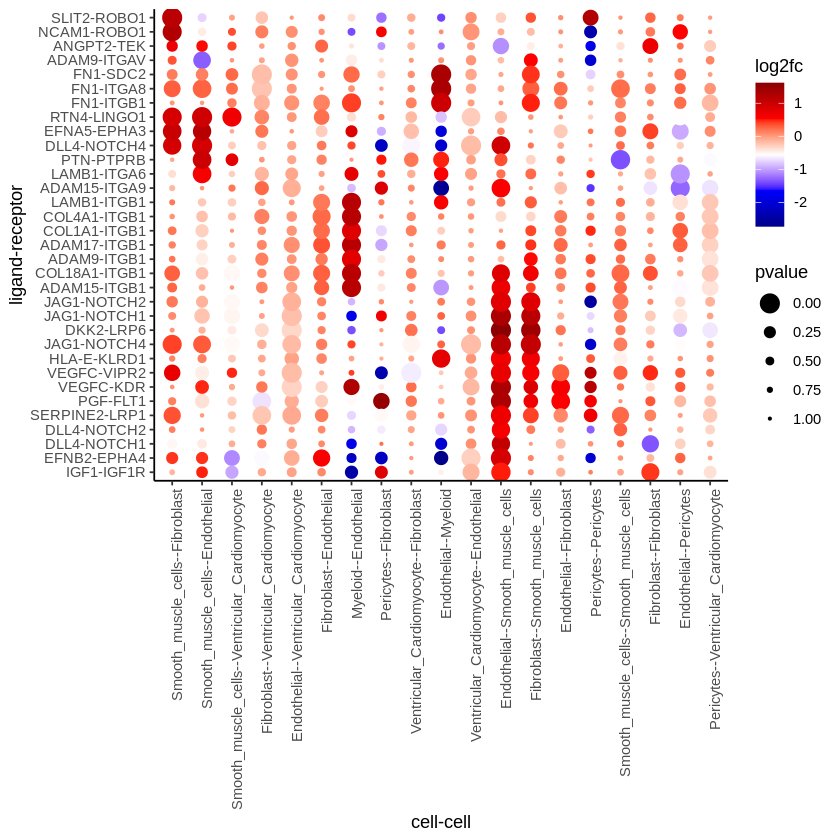

In [10]:
plotCCcomDotplot(gobject = my_giotto_object,
                 comScores = spatial_all_scores,
                 selected_LR = top_LR_ints,
                 selected_cell_LR = top_LR_cell_ints,
                 cluster_on = 'PI')

In [ ]:
selected_spat = spatial_all_scores[p.adj <= 0.25 & abs(log2fc) > 0.1 & lig_nr >= 5 & rec_nr >= 5 & lig_expr > 0.5 & rec_expr > 0.5]
# selected_spat = spatial_all_scores[p.adj <= 0.1 & abs(log2fc) > 0.1 & lig_nr >= 5 & rec_nr >= 5 & LR_comb == 'JAG1-NOTCH2']
data.table::setorder(selected_spat, -PI)

In [12]:
spatial_all_scores[(ligand == 'SLIT3') & (receptor == 'ROBO1')]

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>


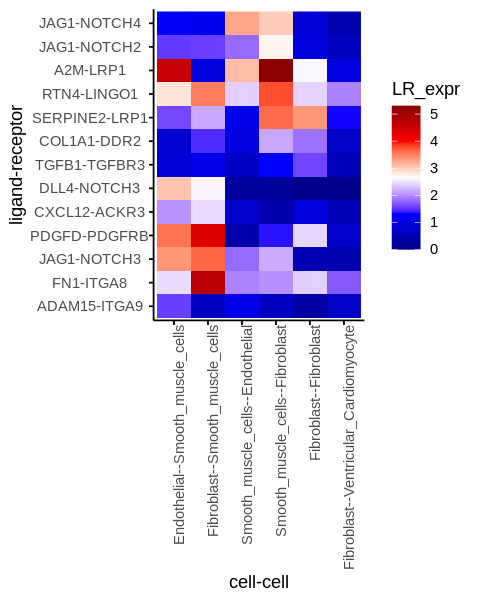

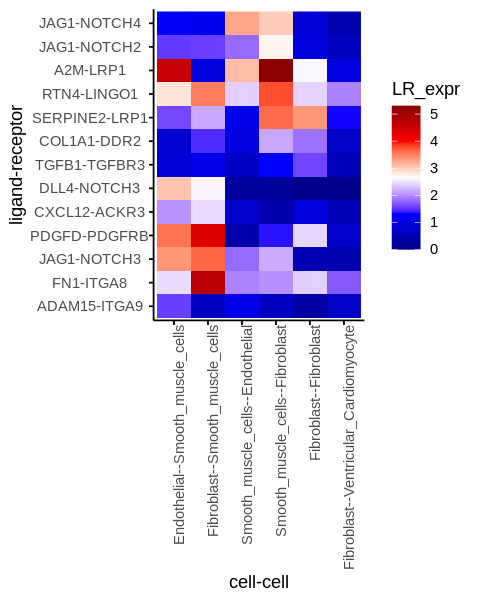

In [127]:
## select top LR ##
selected_spat = spatial_all_scores[p.adj <= 0.25 & abs(log2fc) > 0.1 & lig_nr > 10 & rec_nr > 10 & lig_expr > 0.5 & rec_expr > 0.5]
# selected_spat = spatial_all_scores[p.adj <= 0.5 & abs(log2fc) > 0.1 & lig_nr >= 10 & rec_nr >= 10]
data.table::setorder(selected_spat, -PI)

top_LR_ints = unique(selected_spat[order(-abs(PI))]$LR_comb)[1:30]
top_LR_cell_ints = unique(selected_spat[order(-abs(PI))]$LR_cell_comb)[1:30]

plotCCcomHeatmap(gobject = my_giotto_object,
                 comScores = spatial_all_scores,
                 selected_LR = top_LR_ints,
                 selected_cell_LR = top_LR_cell_ints,
                 show = 'LR_expr')

In [148]:
gobject = my_giotto_object
# comScores = spatial_all_scores
comScores = selected_spat
selected_LR = top_LR_ints
selected_cell_LR = top_LR_cell_ints
show_LR_names = TRUE
show_cell_LR_names = TRUE
cluster_on = c('PI', 'LR_expr', 'log2fc')
cor_method = c("pearson", "kendall", "spearman")
aggl_method = c("ward.D", "ward.D2", "single", "complete", "average", "mcquitty", "median", "centroid")
show_plot = NA
return_plot = NA
save_plot = NA
save_param =  list()
default_save_name = 'plotCCcomDotplot'

In [149]:
dt_to_matrix <- function(x) {
  rownames = as.character(x[[1]])
  mat = methods::as(Matrix::as.matrix(x[,-1]), 'Matrix')
  rownames(mat) = rownames
  return(mat)
}

cor_giotto = function(x, ...) {
  x = as.matrix(x)
  return(stats::cor(x, ...))
}

t_giotto = function(mymatrix) {

  if(methods::is(mymatrix, 'dgCMatrix')) {
    return(Matrix::t(mymatrix)) # replace with sparseMatrixStats
  } else if(methods::is(mymatrix, 'Matrix')) {
    return(Matrix::t(mymatrix))
  } else {
    mymatrix = as.matrix(mymatrix)
    mymatrix = base::t(mymatrix)
    return(mymatrix)
  }
}

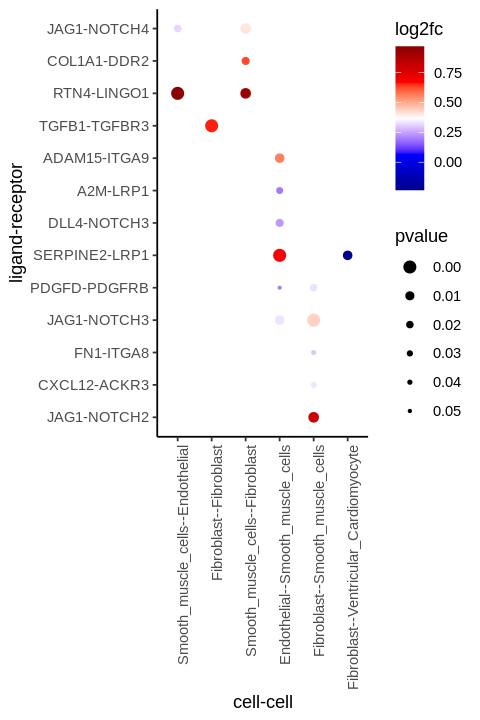

In [150]:
cor_method = 'pearson'
aggl_method = 'ward.D'
selDT = comScores[LR_comb %in% selected_LR & LR_cell_comb %in% selected_cell_LR]

cluster_on = 'PI'
selDT_d = data.table::dcast.data.table(selDT, LR_cell_comb~LR_comb, value.var = cluster_on, fill = 0)
selDT_m = dt_to_matrix(selDT_d)

# remove zero variance
sd_rows = apply(selDT_m, 1, sd)
sd_rows_zero = names(sd_rows[sd_rows == 0])
if(length(sd_rows_zero) > 0) selDT_m = selDT_m[!rownames(selDT_m) %in% sd_rows_zero, ]

sd_cols = apply(selDT_m, 2, sd)
sd_cols_zero = names(sd_cols[sd_cols == 0])
if(length(sd_cols_zero) > 0) selDT_m = selDT_m[, !colnames(selDT_m) %in% sd_cols_zero]

## cells
corclus_cells_dist = stats::as.dist(1-cor_giotto(x = t_giotto(selDT_m), method = cor_method))
hclusters_cells = stats::hclust(d = corclus_cells_dist, method = aggl_method)
# clus_names = rownames(selDT_m)
# names(clus_names) = 1:length(clus_names)
# # clus_sort_names = clus_names[hclusters_cells$order]
# clus_sort_names = clus_names[order(clus_names)]

##############################################
# reorder cells
clus_names = rownames(selDT_m)
split_clus_names = strsplit(clus_names, split = "--")
clus_names_R = c(split_clus_names[[1]][2])
clus_names_L = c(split_clus_names[[1]][1])
for (i in 2:length(clus_names)){
    clus_names_R = c(clus_names_R, split_clus_names[[i]][2])
    clus_names_L = c(clus_names_L, split_clus_names[[i]][1])
    }

clus_names_L_reorder = clus_names_L[order(clus_names_R)]
clus_names_R_reorder = clus_names_R[order(clus_names_R)]
clus_names_reorderR = clus_names[order(clus_names_R)]


Receptors = unique(clus_names_R[order(clus_names_R)])
clus_names_reorder = c(clus_names_reorderR[clus_names_R[order(clus_names_R)] == Receptors[1]][order(clus_names_L_reorder[clus_names_R[order(clus_names_R)] == Receptors[1]])])
for (i in 2:length(Receptors)){
    clus_names_reorder = c(clus_names_reorder, clus_names_reorderR[clus_names_R[order(clus_names_R)] == Receptors[i]][order(clus_names_L_reorder[clus_names_R[order(clus_names_R)] == Receptors[i]])])
    }
clus_sort_names = clus_names_reorder
##############################################
selDT[, LR_cell_comb := factor(LR_cell_comb, clus_sort_names)]



## genes
corclus_genes_dist = stats::as.dist(1-cor_giotto(x = selDT_m, method = cor_method))
hclusters_genes = stats::hclust(d = corclus_genes_dist, method = aggl_method)
clus_names = colnames(selDT_m)
names(clus_names) = 1:length(clus_names)
clus_sort_names = clus_names[hclusters_genes$order]
selDT[, LR_comb := factor(LR_comb, clus_sort_names)]

pl = ggplot2::ggplot()
pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
                                             y = 'LR_comb', size = 'pvalue', color = 'log2fc'))
pl = pl + ggplot2::theme_classic()
if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = ggplot2::element_text(),
                                         axis.ticks.y = ggplot2::element_line())
if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, vjust = 1, hjust = 1),
                                              axis.ticks.x = ggplot2::element_line())
pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'white', 'red', 'darkred'))
pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.5)) + ggplot2::scale_color_gradientn(colours = c('darkblue', 'blue', 'white', 'red', 'darkred'))
pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')


# # print, return and save parameters
# show_plot = ifelse(is.na(show_plot), readGiottoInstructions(gobject, param = 'show_plot'), show_plot)
# save_plot = ifelse(is.na(save_plot), readGiottoInstructions(gobject, param = 'save_plot'), save_plot)
# return_plot = ifelse(is.na(return_plot), readGiottoInstructions(gobject, param = 'return_plot'), return_plot)
print(pl)
## print plot
# if(show_plot == TRUE) {
# print(pl)
# }

In [151]:
# write.csv(selDT, '/home/share/xwanaf/sour_sep/newCKPT/MerM/giotto_data/selDT.csv', row.names = FALSE)

In [152]:
# pl = ggplot2::ggplot()
# pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
#                                              y = 'LR_comb', size = 'pvalue', color = 'log2fc'))
# options(repr.plot.width = 8, repr.plot.height = 10)
# pl = pl + ggplot2::theme_classic()
# if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = ggplot2::element_text(),
#                                          axis.ticks.y = ggplot2::element_line())
# if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, vjust = 1, hjust = 1),
#                                               axis.ticks.x = ggplot2::element_line())
# # pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'white', 'red', 'darkred'))
# pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'lightblue', 'white', 'red'))
# # pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.5)) + ggplot2::scale_color_gradientn(colours = c('darkblue', 'blue', 'white', 'red', 'darkred'))
# pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.5)) + ggplot2::scale_color_gradientn(colours = c('darkblue', 'blue', 'lightblue', 'white', 'red'))

# pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')

# print(pl)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



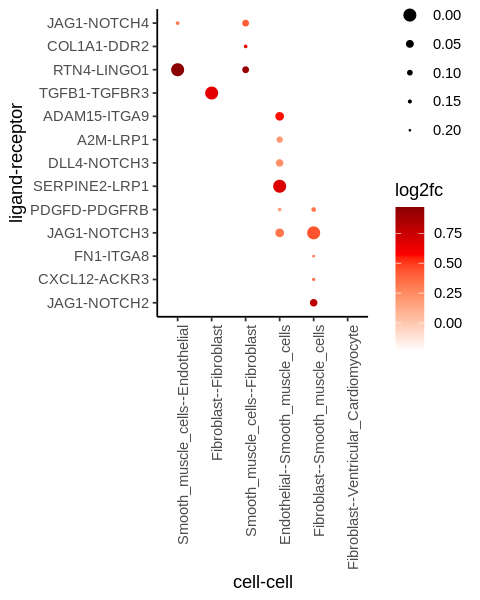

In [153]:
pl = ggplot2::ggplot()
# pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
#                                              y = 'LR_comb', size = 'pvalue', color = 'log2fc'))
pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
                                             y = 'LR_comb', size = 'p.adj', color = 'log2fc'))
options(repr.plot.width = 4, repr.plot.height = 5)
pl = pl + ggplot2::theme_classic()
if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = ggplot2::element_text(),
                                         axis.ticks.y = ggplot2::element_line())
if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, vjust = 1, hjust = 1),
                                              axis.ticks.x = ggplot2::element_line())
# pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'white', 'red', 'darkred'))
# pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'lightblue', 'white', 'red'))
# pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'white', 'red'))
pl = pl + ggplot2::scale_fill_gradientn(colours = c('white', 'lightsalmon', 'red', 'darkred'))
pl = pl + ggplot2::scale_color_gradientn(colours=c('darkblue','blue', 'white', 'red','darkred'))
# pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.5)) + ggplot2::scale_color_gradientn(colours = c('darkblue', 'blue', 'white', 'red', 'darkred'))
# pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.1), limits = c(0, 0.2)) + ggplot2::scale_color_gradientn(colours = c('darkblue', 'blue', 'white', 'red'))
pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.1), limits = c(0, 0.2)) + ggplot2::scale_color_gradientn(colours = c('white', 'lightsalmon', 'red', 'darkred'))

pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')

print(pl)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



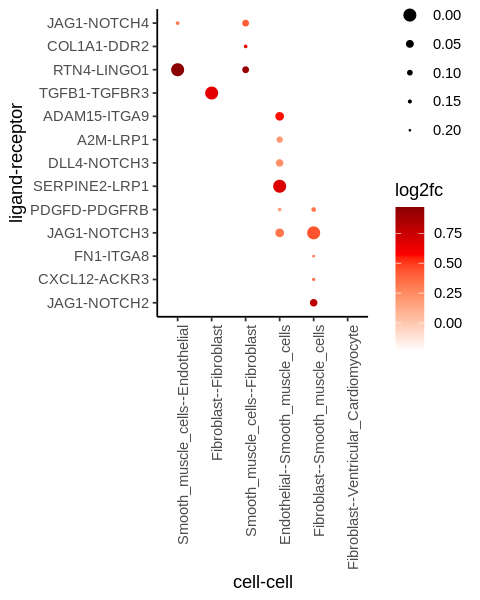

In [154]:
pl = ggplot2::ggplot()
# pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
#                                              y = 'LR_comb', size = 'pvalue', color = 'log2fc'))
pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
                                             y = 'LR_comb', size = 'p.adj', color = 'log2fc'))
options(repr.plot.width = 4, repr.plot.height = 5)
pl = pl + ggplot2::theme_classic()
if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = ggplot2::element_text(),
                                         axis.ticks.y = ggplot2::element_line())
if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, vjust = 1, hjust = 1),
                                              axis.ticks.x = ggplot2::element_line())
# pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'white', 'red', 'darkred'))
# pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'lightblue', 'white', 'red'))
# pl = pl + ggplot2::scale_fill_gradientn(colours = c('darkblue', 'blue', 'white', 'red'))
pl = pl + ggplot2::scale_fill_gradientn(colours = c('white', 'lightsalmon', 'red', 'darkred'))
pl = pl + ggplot2::scale_color_gradientn(colours=c('darkblue','blue', 'white', 'red','darkred'))
# pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.5)) + ggplot2::scale_color_gradientn(colours = c('darkblue', 'blue', 'white', 'red', 'darkred'))
# pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.1), limits = c(0, 0.2)) + ggplot2::scale_color_gradientn(colours = c('darkblue', 'blue', 'white', 'red'))
pl = pl + ggplot2::scale_size_continuous(range = c(3, 0.1), limits = c(0, 0.2)) + ggplot2::scale_color_gradientn(colours = c('white', 'lightsalmon', 'red', 'darkred'))

pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')

print(pl)

In [155]:
# array(['Endothelial', 'Fibroblast', 'Lymphoid', 'Myeloid', 'Neuronal',
#        'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte'],
#       dtype=object)

In [156]:
selDT[(selDT$lig_cell_type == 'Myeloid') & (selDT$rec_cell_type == 'Endothelial')]

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>


In [157]:
selDT[(selDT$lig_cell_type == 'Endothelial') & (selDT$rec_cell_type == 'Smooth_muscle_cells')]

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
SERPINE2-LRP1,Endothelial,0.8821606,SERPINE2,Smooth_muscle_cells,0.7238008,LRP1,1.605961,45,41,0.9649785,0.6409829,0.6797607,0.000,Endothelial--Smooth_muscle_cells,0.00000000,1.3056971
ADAM15-ITGA9,Endothelial,0.9791948,ADAM15,Smooth_muscle_cells,0.5732272,ITGA9,1.552422,45,41,1.0205055,0.5319165,0.5604324,0.008,Endothelial--Smooth_muscle_cells,0.03600000,0.8090949
JAG1-NOTCH3,Endothelial,1.1053646,JAG1,Smooth_muscle_cells,2.2582759,NOTCH3,3.363640,45,41,2.6518967,0.7117437,0.3318628,0.008,Endothelial--Smooth_muscle_cells,0.03600000,0.4791095
DLL4-NOTCH3,Endothelial,0.8002950,DLL4,Smooth_muscle_cells,2.2582759,NOTCH3,3.058571,45,41,2.5862808,0.4722900,0.2336618,0.016,Endothelial--Smooth_muscle_cells,0.05760000,0.2896419
A2M-LRP1,Endothelial,3.8846267,A2M,Smooth_muscle_cells,0.7238008,LRP1,4.608427,45,41,4.0209976,0.5874298,0.1922517,0.024,Endothelial--Smooth_muscle_cells,0.08228571,0.2085307
PDGFD-PDGFRB,Endothelial,1.0304364,PDGFD,Smooth_muscle_cells,2.5353614,PDGFRB,3.565798,45,41,3.0924062,0.4733917,0.1994830,0.052,Endothelial--Smooth_muscle_cells,0.16904348,0.1540012


In [158]:
min(selDT$log2fc)

[1] -0.2325049

In [165]:
selDT[log2fc == min(selDT$log2fc)]$log2fc = -0.3

In [167]:
selDT

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
RTN4-LINGO1,Smooth_muscle_cells,0.8793521,RTN4,Endothelial,1.5048799,LINGO1,2.384232,41,45,1.1699542,1.2142778,0.9680234,0.000,Smooth_muscle_cells--Endothelial,0.00000000,1.8593976
SERPINE2-LRP1,Endothelial,0.8821606,SERPINE2,Smooth_muscle_cells,0.7238008,LRP1,1.605961,45,41,0.9649785,0.6409829,0.6797607,0.000,Endothelial--Smooth_muscle_cells,0.00000000,1.3056971
RTN4-LINGO1,Smooth_muscle_cells,1.0054810,RTN4,Fibroblast,2.7735005,LINGO1,3.778981,28,36,1.9467534,1.8322281,0.9223406,0.004,Smooth_muscle_cells--Fibroblast,0.07200000,1.0539286
JAG1-NOTCH2,Fibroblast,1.0529821,JAG1,Smooth_muscle_cells,0.5056152,NOTCH2,1.558597,36,28,0.8531829,0.7054145,0.7991388,0.004,Fibroblast--Smooth_muscle_cells,0.05760000,0.9905944
ADAM15-ITGA9,Endothelial,0.9791948,ADAM15,Smooth_muscle_cells,0.5732272,ITGA9,1.552422,45,41,1.0205055,0.5319165,0.5604324,0.008,Endothelial--Smooth_muscle_cells,0.03600000,0.8090949
JAG1-NOTCH3,Fibroblast,1.0529821,JAG1,Smooth_muscle_cells,2.5971751,NOTCH3,3.650157,36,28,2.6666231,0.9835341,0.4388250,0.000,Fibroblast--Smooth_muscle_cells,0.00000000,0.5787043
COL1A1-DDR2,Smooth_muscle_cells,0.5387743,COL1A1,Fibroblast,1.6158163,DDR2,2.154591,28,36,1.3582296,0.7963610,0.6286476,0.016,Smooth_muscle_cells--Fibroblast,0.16457143,0.4926369
JAG1-NOTCH3,Endothelial,1.1053646,JAG1,Smooth_muscle_cells,2.2582759,NOTCH3,3.363640,45,41,2.6518967,0.7117437,0.3318628,0.008,Endothelial--Smooth_muscle_cells,0.03600000,0.4791095
JAG1-NOTCH4,Smooth_muscle_cells,2.1747544,JAG1,Fibroblast,0.8322134,NOTCH4,3.006968,28,36,2.2420046,0.7649631,0.4077633,0.004,Smooth_muscle_cells--Fibroblast,0.07200000,0.4659379


Warning message:
“Removed 1 rows containing missing values (geom_point).”


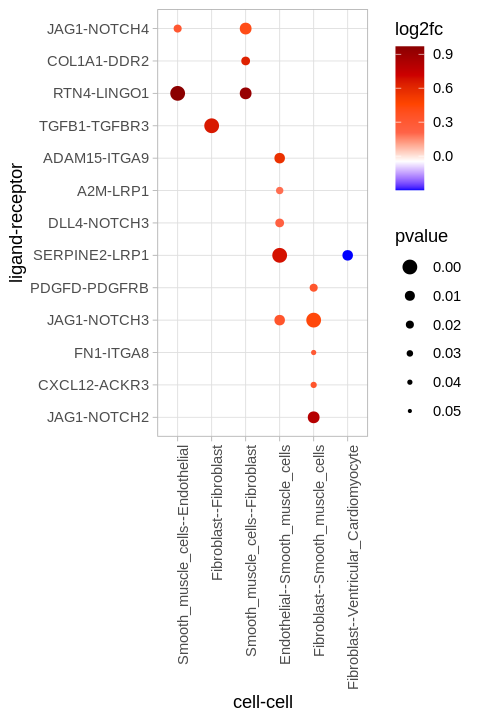

In [166]:
pl = ggplot2::ggplot()
pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
                                             y = 'LR_comb', size = 'pvalue', color = 'log2fc'))
options(repr.plot.width = 4, repr.plot.height = 6)
pl = pl + ggplot2::theme_light()
if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = ggplot2::element_text(),
                                         axis.ticks.y = ggplot2::element_line())
if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, vjust = 1, hjust = 1),
                                              axis.ticks.x = ggplot2::element_line())
#pl = pl + ggplot2::scale_color_gradient2(low="blue", mid="white", high="red")
pl = pl + ggplot2::scale_color_gradientn(colours=c('blue', 'white', 'tomato', 'orangered', 'red3', 'darkred'))
pl = pl + ggplot2::scale_size_continuous(range = c(3.5, 0.5), limits = c(0, 0.05)) 
pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')
print(pl)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


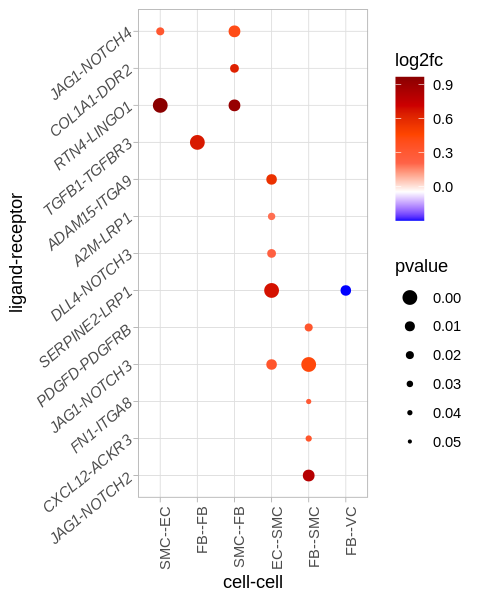

In [184]:
pl = ggplot2::ggplot()
pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
                                             y = 'LR_comb', size = 'pvalue', color = 'log2fc'))
options(repr.plot.width = 4, repr.plot.height = 5)
pl = pl + ggplot2::theme_light()
if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = ggplot2::element_text(face="italic",angle=40),
                                         axis.ticks.y = ggplot2::element_line())
if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, vjust = 1, hjust = 1),
                                              axis.ticks.x = ggplot2::element_line())
#pl = pl + ggplot2::scale_color_gradient2(low="blue", mid="white", high="red")
pl = pl + ggplot2::scale_color_gradientn(colours=c('blue', 'white', 'tomato', 'orangered', 'red3', 'darkred'))
pl = pl + ggplot2::scale_size_continuous(range = c(3.5, 0.5), limits = c(0, 0.05)) 
pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')
pl = pl + ggplot2::scale_x_discrete(labels=c("Smooth_muscle_cells--Endothelial" = "SMC--EC",
                                            "Endothelial--Smooth_muscle_cells" = "EC--SMC",
                                            "Smooth_muscle_cells--Fibroblast" = "SMC--FB",
                                            "Fibroblast--Smooth_muscle_cells" = "FB--SMC",
                                            "Fibroblast--Fibroblast" = "FB--FB",
                                            "Fibroblast--Ventricular_Cardiomyocyte" = "FB--VC"))
print(pl)

In [176]:
selDT

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
RTN4-LINGO1,Smooth_muscle_cells,0.8793521,RTN4,Endothelial,1.5048799,LINGO1,2.384232,41,45,1.1699542,1.2142778,0.9680234,0.000,Smooth_muscle_cells--Endothelial,0.00000000,1.8593976
SERPINE2-LRP1,Endothelial,0.8821606,SERPINE2,Smooth_muscle_cells,0.7238008,LRP1,1.605961,45,41,0.9649785,0.6409829,0.6797607,0.000,Endothelial--Smooth_muscle_cells,0.00000000,1.3056971
RTN4-LINGO1,Smooth_muscle_cells,1.0054810,RTN4,Fibroblast,2.7735005,LINGO1,3.778981,28,36,1.9467534,1.8322281,0.9223406,0.004,Smooth_muscle_cells--Fibroblast,0.07200000,1.0539286
JAG1-NOTCH2,Fibroblast,1.0529821,JAG1,Smooth_muscle_cells,0.5056152,NOTCH2,1.558597,36,28,0.8531829,0.7054145,0.7991388,0.004,Fibroblast--Smooth_muscle_cells,0.05760000,0.9905944
ADAM15-ITGA9,Endothelial,0.9791948,ADAM15,Smooth_muscle_cells,0.5732272,ITGA9,1.552422,45,41,1.0205055,0.5319165,0.5604324,0.008,Endothelial--Smooth_muscle_cells,0.03600000,0.8090949
JAG1-NOTCH3,Fibroblast,1.0529821,JAG1,Smooth_muscle_cells,2.5971751,NOTCH3,3.650157,36,28,2.6666231,0.9835341,0.4388250,0.000,Fibroblast--Smooth_muscle_cells,0.00000000,0.5787043
COL1A1-DDR2,Smooth_muscle_cells,0.5387743,COL1A1,Fibroblast,1.6158163,DDR2,2.154591,28,36,1.3582296,0.7963610,0.6286476,0.016,Smooth_muscle_cells--Fibroblast,0.16457143,0.4926369
JAG1-NOTCH3,Endothelial,1.1053646,JAG1,Smooth_muscle_cells,2.2582759,NOTCH3,3.363640,45,41,2.6518967,0.7117437,0.3318628,0.008,Endothelial--Smooth_muscle_cells,0.03600000,0.4791095
JAG1-NOTCH4,Smooth_muscle_cells,2.1747544,JAG1,Fibroblast,0.8322134,NOTCH4,3.006968,28,36,2.2420046,0.7649631,0.4077633,0.004,Smooth_muscle_cells--Fibroblast,0.07200000,0.4659379


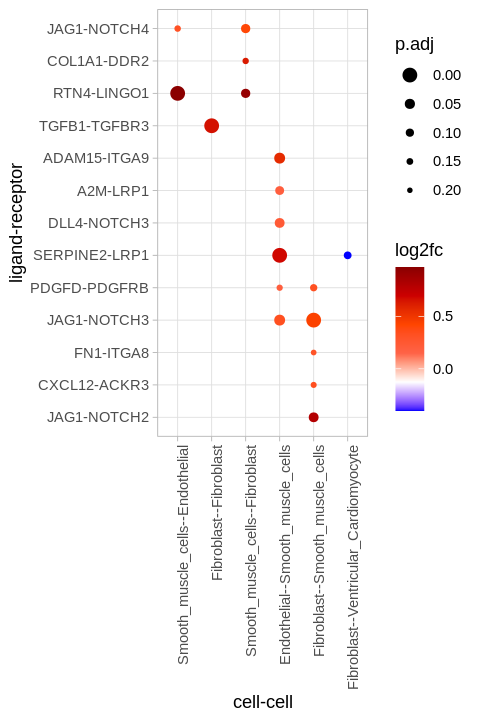

In [144]:
pl = ggplot2::ggplot()
pl = pl + ggplot2::geom_point(data = selDT, ggplot2::aes_string(x = 'LR_cell_comb',
                                             y = 'LR_comb', size = 'p.adj', color = 'log2fc'))
options(repr.plot.width = 4, repr.plot.height = 6)
pl = pl + ggplot2::theme_light()
if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = ggplot2::element_text(),
                                         axis.ticks.y = ggplot2::element_line())
if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, vjust = 1, hjust = 1),
                                              axis.ticks.x = ggplot2::element_line())
#pl = pl + ggplot2::scale_color_gradient2(low="blue", mid="white", high="red")
pl = pl + ggplot2::scale_color_gradientn(colours=c('blue', 'white', 'tomato', 'orangered', 'red3', 'darkred'))
pl = pl + ggplot2::scale_size_continuous(range = c(3.5, 0.9), limits = c(0, 0.2)) 
pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')
print(pl)